In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [88]:
# Load datasets
Z1 = pd.read_csv("Z1_CAJICA_ambient-weather-20250604-20251104.csv")
Z2 = pd.read_csv("Z2_GIRALDA_ambient-weather-20250604-20251104.csv")
Z3 = pd.read_csv("Z3_OIKOS_ambient-weather-20250604-20251104.csv")


In [89]:
def select_relevant_columns(df):
    """
    Select critical variables for analysis
    """
    critical_vars = [
        'Date',
        'Simple Date',
        'Outdoor Temperature (°C)',
        'Wind Speed (m/sec)',
        'Wind Gust (m/sec)',
        'Max Daily Gust (m/sec)',
        'Wind Direction (°)',
        'Humidity (%)',
        'Solar Radiation (W/m^2)',  # For solar energy potential
        'Absolute Pressure (mmHg)'   # Indicator of meteorological changes
    ]
    
    return df[critical_vars].copy()

In [90]:
def handle_missing_values(df, station_name):
    """
    Specific strategy for temporal meteorological data
    """
    # 1. Identify missing data patterns
    missing_report = df.isnull().sum()
    print(f"\n=== Missing Values Report for {station_name} ===")
    print(missing_report[missing_report > 0])
    
    # 2. CONVERT Date TO DATETIME AND SET AS INDEX
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
        df = df.sort_index()
    
    # 3. Identify long temporal gaps (sensor failure)
    time_diff = df.index.to_series().diff()
    expected_interval = pd.Timedelta(minutes=5)
    long_gaps = time_diff[time_diff > expected_interval * 2]
    
    print(f"\nDetected {len(long_gaps)} long gaps (>10 min)")
    
    # 4. Imputation strategy by variable type
    
    # CRITICAL wind variables (DO NOT impute, flag as missing)
    wind_vars = ['Wind Speed (m/sec)', 'Wind Gust (m/sec)', 
                 'Max Daily Gust (m/sec)', 'Wind Direction (°)']
    
    for var in wind_vars:
        if var in df.columns:
            missing_count = df[var].isnull().sum()
            if missing_count > 0:
                print(f"\n⚠️  WARNING: {missing_count} missing values in {var}")
                print(f"   These will be flagged for interpolation or exclusion")
                # Flag but DO NOT automatically impute
                df[f'{var}_is_missing'] = df[var].isnull()
    
    # Ambient variables (limited temporal interpolation)
    ambient_vars = ['Outdoor Temperature (°C)', 'Humidity (%)', 
                    'Absolute Pressure (mmHg)']
    
    for var in ambient_vars:
        if var in df.columns and df[var].isnull().sum() > 0:
            # Temporal linear interpolation
            df[var] = df[var].interpolate(
                method='time', 
                limit=6,  # Maximum 6 records (30 min)
                limit_direction='both'
            )
            # Remaining missing values filled with forward/backward fill
            df[var] = df[var].ffill(limit=2)  # UPDATED
            df[var] = df[var].bfill(limit=2)  # UPDATED
    
    # Solar radiation (fill with 0 during nighttime hours)
    if 'Solar Radiation (W/m^2)' in df.columns:
        df['hour'] = df.index.hour
        df.loc[(df['Solar Radiation (W/m^2)'].isnull()) & 
               ((df['hour'] < 6) | (df['hour'] > 18)), 
               'Solar Radiation (W/m^2)'] = 0
        
        # Temporal interpolation for the rest
        df['Solar Radiation (W/m^2)'] = df['Solar Radiation (W/m^2)'].interpolate(
            method='time', limit=6, limit_direction='both'
        )
        df = df.drop('hour', axis=1)
    
    return df

In [91]:
def validate_physical_consistency(df):
    """
    Verify that data complies with physical laws
    """
    issues = []
    
    # 1. Wind Gust must be >= Wind Speed
    if 'Wind Gust (m/sec)' in df.columns and 'Wind Speed (m/sec)' in df.columns:
        invalid_gust = df[df['Wind Gust (m/sec)'] < df['Wind Speed (m/sec)']]
        if len(invalid_gust) > 0:
            issues.append(f"⚠️  {len(invalid_gust)} records: Gust < Speed")
            # Correct: Gust = Speed if invalid
            df.loc[df['Wind Gust (m/sec)'] < df['Wind Speed (m/sec)'], 
                   'Wind Gust (m/sec)'] = df['Wind Speed (m/sec)']
    
    # 2. Wind Direction must be in [0, 360)
    if 'Wind Direction (°)' in df.columns:
        invalid_dir = df[(df['Wind Direction (°)'] < 0) | 
                         (df['Wind Direction (°)'] >= 360)]
        if len(invalid_dir) > 0:
            issues.append(f"⚠️  {len(invalid_dir)} records: Invalid wind direction")
            df['Wind Direction (°)'] = df['Wind Direction (°)'] % 360
    
    # 3. Temperature must be in reasonable range for Colombia
    if 'Outdoor Temperature (°C)' in df.columns:
        invalid_temp = df[(df['Outdoor Temperature (°C)'] < 0) | 
                          (df['Outdoor Temperature (°C)'] > 40)]
        if len(invalid_temp) > 0:
            issues.append(f"⚠️  {len(invalid_temp)} records: Extreme temperature")
    
    # 4. Humidity must be in [0, 100]
    if 'Humidity (%)' in df.columns:
        invalid_hum = df[(df['Humidity (%)'] < 0) | 
                         (df['Humidity (%)'] > 100)]
        if len(invalid_hum) > 0:
            issues.append(f"⚠️  {len(invalid_hum)} records: Invalid humidity")
            df['Humidity (%)'] = df['Humidity (%)'].clip(0, 100)
    
    # 5. Negative solar radiation
    if 'Solar Radiation (W/m^2)' in df.columns:
        if (df['Solar Radiation (W/m^2)'] < 0).any():
            issues.append("⚠️  Negative solar radiation detected")
            df['Solar Radiation (W/m^2)'] = df['Solar Radiation (W/m^2)'].clip(lower=0)
    
    # Print results
    if issues:
        print("\n=== Physical Consistency Issues ===")
        for issue in issues:
            print(issue)
    else:
        print("\n✅ All physical consistency checks passed")
    
    return df

In [92]:
def flag_extreme_events(df):
    """
    Identify and flag extreme wind events based on thresholds
    
    """
    # Define operational thresholds (according to ISO 4302)
    WIND_WARNING_THRESHOLD = 10.0  # m/s 
    WIND_CRITICAL_THRESHOLD = 13.0  # m/s

    # Create condition flags
    df['wind_warning'] = df['Wind Speed (m/sec)'] >= WIND_WARNING_THRESHOLD
    df['wind_critical'] = df['Wind Speed (m/sec)'] >= WIND_CRITICAL_THRESHOLD
    df['gust_warning'] = df['Wind Gust (m/sec)'] >= WIND_WARNING_THRESHOLD
    df['gust_critical'] = df['Wind Gust (m/sec)'] >= WIND_CRITICAL_THRESHOLD
    
    # Extreme events summary
    warning_events = df[df['wind_warning'] | df['gust_warning']]
    critical_events = df[df['wind_critical'] | df['gust_critical']]
    
    print(f"\n=== Extreme Events Summary ===")
    print(f"Warning-level events: {len(warning_events)}")
    print(f"Critical-level events: {len(critical_events)}")
    
    if len(critical_events) > 0:
        print(f"\nCritical events detected at:")
        print(critical_events[['Date', 'Wind Speed (m/sec)', 
                               'Wind Gust (m/sec)']].head(10))
    
    return df

In [93]:
def clean_weather_station_data(df, station_name):
    """
    Clean and preprocess weather station data
    """
    print(f"\n{'='*60}")
    print(f"CLEANING DATA FOR STATION: {station_name}")
    print(f"{'='*60}")
    
    # Paso 1: Seleccionar variables relevantes
    df_clean = select_relevant_columns(df)
    print(f"\n✓ Selected {len(df_clean.columns)} relevant variables")
    
    # Paso 2: Remover filas completamente vacías (si existen)
    df_clean = df_clean.dropna(how='all')
    
    # Paso 3: Remover duplicados temporales exactos
    initial_rows = len(df_clean)
    df_clean = df_clean.drop_duplicates(subset=['Date'], keep='first')
    removed_dups = initial_rows - len(df_clean)
    if removed_dups > 0:
        print(f"\n✓ Removed {removed_dups} duplicate timestamps")
    
    # Paso 4: Manejo inteligente de missing values
    df_clean = handle_missing_values(df_clean, station_name)
    
    # Paso 5: Validación física
    df_clean = validate_physical_consistency(df_clean)
    
    # Paso 6: Identificar (NO eliminar) eventos extremos
    df_clean = flag_extreme_events(df_clean)
    
    # Paso 7: Verificar si aún quedan valores críticos faltantes
    critical_vars = ['Wind Speed (m/sec)', 'Wind Direction (°)']
    remaining_missing = df_clean[critical_vars].isnull().sum()
    
    if remaining_missing.sum() > 0:
        print(f"\n⚠️  ATTENTION: Critical variables still have missing values:")
        print(remaining_missing[remaining_missing > 0])
        print(f"\nOptions:")
        print(f"  1. Use spatial interpolation from other stations")
        print(f"  2. Exclude these timestamps from analysis")
        print(f"  3. Apply conservative interpolation (mark as low confidence)")
    
    print(f"\n{'='*60}")
    print(f"CLEANING COMPLETE FOR {station_name}")
    print(f"Final dataset: {len(df_clean)} records")
    print(f"{'='*60}\n")
    
    return df_clean

In [94]:
# Cleaning
zona1_clean = clean_weather_station_data(Z1, "Z1_CAJICA")




CLEANING DATA FOR STATION: Z1_CAJICA

✓ Selected 10 relevant variables

=== Missing Values Report for Z1_CAJICA ===
Outdoor Temperature (°C)    322
Wind Speed (m/sec)          322
Wind Gust (m/sec)           322
Max Daily Gust (m/sec)      322
Wind Direction (°)          322
Humidity (%)                322
Solar Radiation (W/m^2)     322
dtype: int64

Detected 26 long gaps (>10 min)

⚠️  WARNING: 322 missing values in Wind Speed (m/sec)
   These will be flagged for interpolation or exclusion

⚠️  WARNING: 322 missing values in Wind Gust (m/sec)
   These will be flagged for interpolation or exclusion

⚠️  WARNING: 322 missing values in Max Daily Gust (m/sec)
   These will be flagged for interpolation or exclusion

⚠️  WARNING: 322 missing values in Wind Direction (°)
   These will be flagged for interpolation or exclusion

=== Physical Consistency Issues ===
⚠️  1 records: Gust < Speed

=== Extreme Events Summary ===
Warning-level events: 3
Critical-level events: 0

⚠️  ATTENTION: Crit

In [95]:
zona2_clean = clean_weather_station_data(Z2, "Z2_GIRALDA")



CLEANING DATA FOR STATION: Z2_GIRALDA

✓ Selected 10 relevant variables

=== Missing Values Report for Z2_GIRALDA ===
Solar Radiation (W/m^2)    3
dtype: int64

Detected 15 long gaps (>10 min)

✅ All physical consistency checks passed

=== Extreme Events Summary ===
Warning-level events: 0
Critical-level events: 0

CLEANING COMPLETE FOR Z2_GIRALDA
Final dataset: 44030 records



In [96]:
zona3_clean = clean_weather_station_data(Z3, "Z3_OIKOS")


CLEANING DATA FOR STATION: Z3_OIKOS

✓ Selected 10 relevant variables

=== Missing Values Report for Z3_OIKOS ===
Outdoor Temperature (°C)     7
Wind Speed (m/sec)           7
Wind Gust (m/sec)            7
Max Daily Gust (m/sec)       7
Wind Direction (°)           7
Humidity (%)                 7
Solar Radiation (W/m^2)     12
dtype: int64

Detected 24 long gaps (>10 min)

⚠️  WARNING: 7 missing values in Wind Speed (m/sec)
   These will be flagged for interpolation or exclusion

⚠️  WARNING: 7 missing values in Wind Gust (m/sec)
   These will be flagged for interpolation or exclusion

⚠️  WARNING: 7 missing values in Max Daily Gust (m/sec)
   These will be flagged for interpolation or exclusion

⚠️  WARNING: 7 missing values in Wind Direction (°)
   These will be flagged for interpolation or exclusion

✅ All physical consistency checks passed

=== Extreme Events Summary ===
Warning-level events: 10
Critical-level events: 0

⚠️  ATTENTION: Critical variables still have missing value

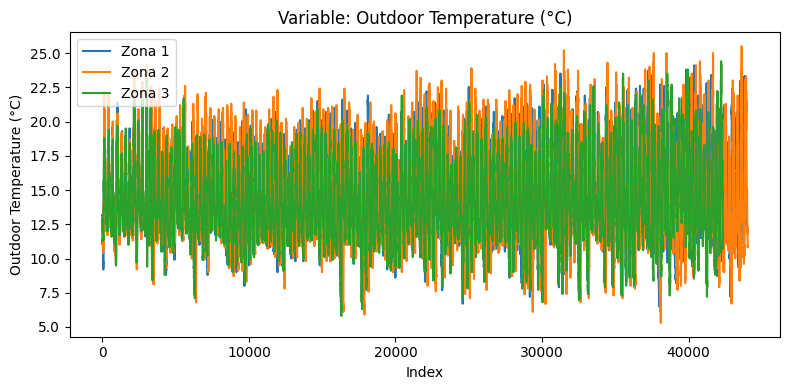

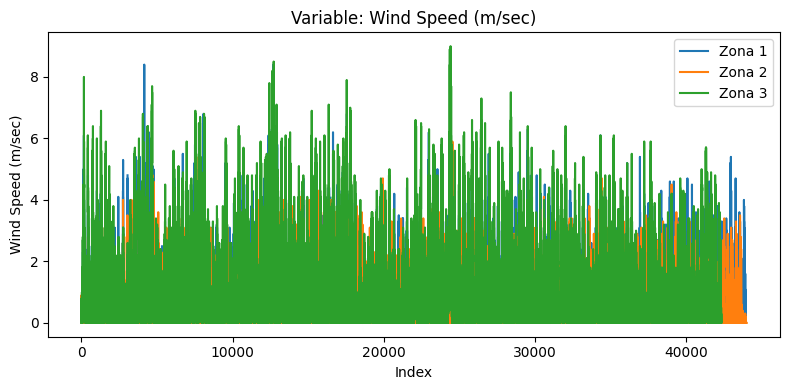

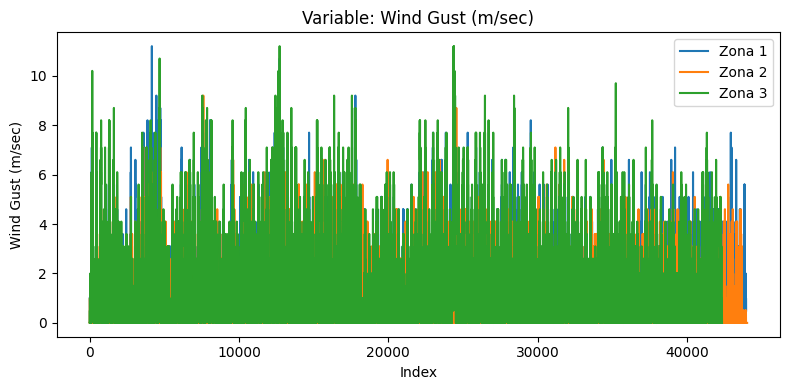

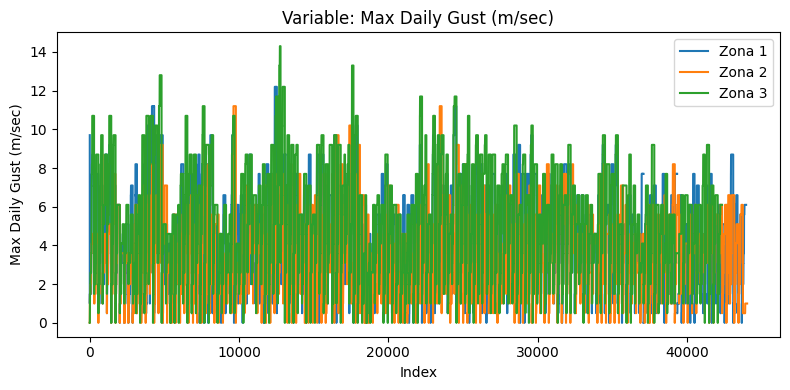

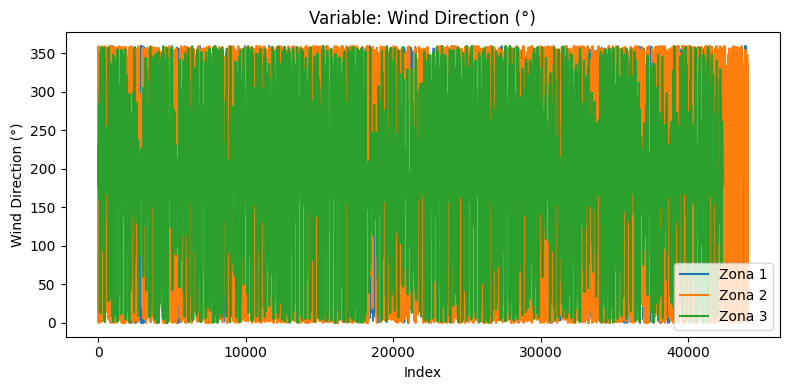

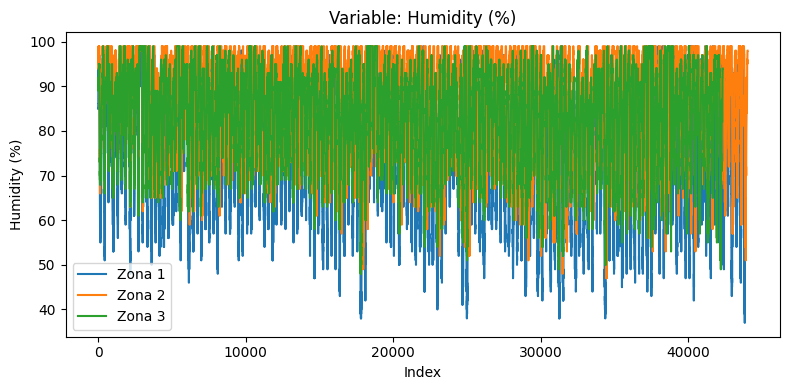

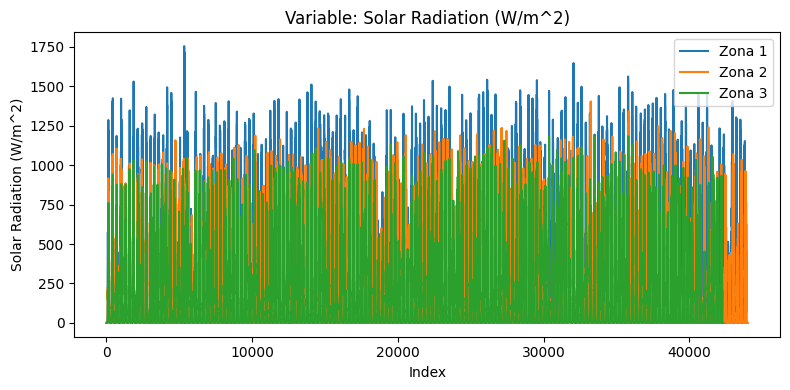

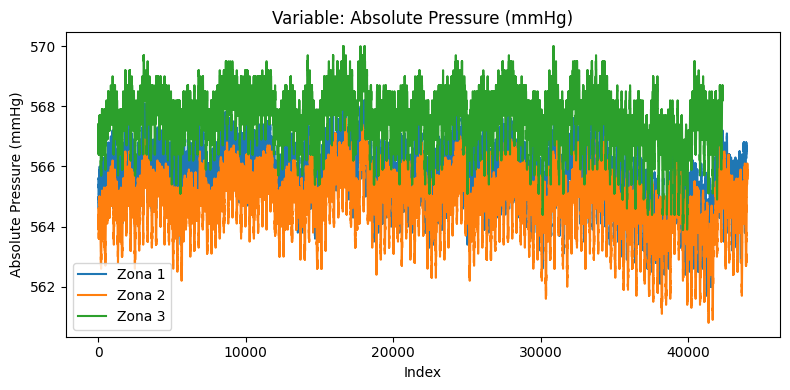

In [97]:
num_cols = zona1_clean.select_dtypes(include=['float64','int64']).columns

for col in num_cols:
    plt.figure(figsize=(8,4))
    plt.plot(zona1_clean[col].values, label='Zona 1')
    plt.plot(zona2_clean[col].values, label='Zona 2')
    plt.plot(zona3_clean[col].values, label='Zona 3')
    plt.title(f"Variable: {col}")
    plt.xlabel("Index")
    plt.ylabel(col)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [98]:
# ============================================================
# SAVE CLEANED DATASETS
# ============================================================

print("\n" + "="*70)
print(" SAVING CLEANED DATASETS")
print("="*70)

# Save individual cleaned stations (with DatetimeIndex)
zona1_clean.to_csv('data/cleaned/z1_cajica_cleaned.csv')
zona2_clean.to_csv('data/cleaned/z2_giralda_cleaned.csv')
zona3_clean.to_csv('data/cleaned/z3_oikos_cleaned.csv')

print("\n✅ Individual cleaned datasets saved:")
print("   - data/cleaned/z1_cajica_cleaned.csv")
print("   - data/cleaned/z2_giralda_cleaned.csv")
print("   - data/cleaned/z3_oikos_cleaned.csv")

# Summary of what was saved
print(f"\n📊 Saved datasets summary:")
print(f"   Z1_CAJICA:  {len(zona1_clean):>6} records, {len(zona1_clean.columns):>2} columns")
print(f"   Z2_GIRALDA: {len(zona2_clean):>6} records, {len(zona2_clean.columns):>2} columns")
print(f"   Z3_OIKOS:   {len(zona3_clean):>6} records, {len(zona3_clean.columns):>2} columns")

print("="*70 + "\n")


 SAVING CLEANED DATASETS

✅ Individual cleaned datasets saved:
   - data/cleaned/z1_cajica_cleaned.csv
   - data/cleaned/z2_giralda_cleaned.csv
   - data/cleaned/z3_oikos_cleaned.csv

📊 Saved datasets summary:
   Z1_CAJICA:   43961 records, 17 columns
   Z2_GIRALDA:  44030 records, 13 columns
   Z3_OIKOS:    42347 records, 17 columns

